# **OPTIMISATION SOUS CONTRAINTES EN CHANCES RARES :** #

## Un Cadre Robuste pour la Gestion du Risque de Queue des Actions Piliers de l’Intelligence Artificielle ##

### Author: Georges Marc-Arthur Sébastien ###

In [1]:
# ==============================================================================
# 1. ACTIVATION ET GESTION DES DÉPENDANCES
# ==============================================================================
import Pkg
Pkg.activate(".")    # Active l'environnement local du dossier
Pkg.instantiate()   # Installe les versions exactes du Manifest.toml
#Pkg.add(["CSV", "DataFrames", "Dates", "Statistics", "LinearAlgebra", "Random", 
        #"Plots", "YFinance", "Distributions", "CovarianceEstimation","Ipopt"])

  Activating project at `C:\Users\Admin`


In [2]:
# ==============================================================================
# 2. IMPORTS ET CONFIGURATION
# ==============================================================================
using Pkg
Pkg.precompile()  # Accélère le chargement initial

using CSV, DataFrames, Dates, Statistics, LinearAlgebra, Random
using Plots, YFinance, Distributions, CovarianceEstimation
using JuMP, Ipopt

Random.seed!(1234) # Reproductibilité des simulations

TaskLocalRNG()

In [3]:
# ==============================================================================
# 3. COLLECTE DES DONNÉES 
# ==============================================================================

# Téléchargement avec gestion des tentatives (Retries)
function safe_get_prices(ticker::String; startdt::Date, enddt::Date, max_tries::Int=6)
    for k in 1:max_tries
        try
            df = get_prices(ticker; startdt=startdt, enddt=enddt) |> DataFrame
            return df
        catch e
            wait = 0.8 * k
            @warn "Échec $ticker (tentative $k/$max_tries). Pause $wait sec" exception=e
            sleep(wait)
        end
    end
    @warn "Ticker $ticker abandonné après $max_tries essais."
    return DataFrame()
end

# Nettoyage unitaire par ticker
function fetch_adjclose(ticker::String, startdt::Date, enddt::Date)
    df = safe_get_prices(ticker; startdt=startdt, enddt=enddt)
    if nrow(df) == 0
        return DataFrame(Date=Date[], Symbol(ticker)=>Float64[])
    end
    rename!(df, Symbol("adjclose") => :AdjClose, Symbol("timestamp") => :Date)
    df.Date = Date.(df.Date)
    df = sort(df, :Date)
    select!(df, :Date, :AdjClose)
    rename!(df, :AdjClose => Symbol(ticker))
    return df
end

# Construction du panel global
function build_prices_panel(tickers::Vector{String}; startdt::Date, enddt::Date)
    prices = fetch_adjclose(tickers[1], startdt, enddt)
    for t in tickers[2:end]
        prices = outerjoin(prices, fetch_adjclose(t, startdt, enddt), on=:Date)
    end
    sort!(prices, :Date)
    return prices
end

build_prices_panel (generic function with 1 method)

In [4]:
# ==============================================================================
# 4. TRANSFORMATION ET NETTOYAGE FINANCIER
# ==============================================================================

# Conversion en données hebdomadaires (Fin de semaine)
function to_weekly_last(prices::DataFrame)
    tmp = copy(prices)
    tmp.week = Dates.week.(tmp.Date)
    tmp.year = Dates.year.(tmp.Date)
    g = groupby(tmp, [:year, :week])
    wk = combine(g) do sdf
        sdf[end, :]   
    end
    select!(wk, Not([:year, :week]))
    sort!(wk, :Date)
    return wk
end

# Calcul des log-rendements hebdomadaires
function weekly_log_returns(prices_w::DataFrame, tickers::Vector{String})
    R = DataFrame(Date = prices_w.Date[2:end])
    for t in tickers
        p = prices_w[!, Symbol(t)]
        r = log.(p[2:end]) .- log.(p[1:end-1])
        R[!, Symbol(t)] = r
    end
    dropmissing!(R)
    return R
end

# Filtrage des actifs ayant trop de données manquantes
function filter_by_nonmissing(rets::DataFrame; min_frac::Float64=0.95)
    N = nrow(rets)
    keep = String[]
    for c in names(rets)
        c == "Date" && continue
        frac = count(!ismissing, rets[!, c]) / N
        if frac >= min_frac
            push!(keep, c)
        end
    end
    rets2 = select(rets, ["Date"; keep])
    dropmissing!(rets2)
    return rets2, keep
end

filter_by_nonmissing (generic function with 1 method)

In [5]:
# ==============================================================================
# 5. PARAMÈTRES ET ACQUISITION
# ==============================================================================

# Définition des univers (Satellite IA et Core Protection)
tickers_ia    = ["NVDA", "AMD", "GOOGL", "AMZN", "MSFT", "META", "ORCL"]
tickers_core5 = ["VFV.TO", "XEI.TO", "TLT", "GC=F", "ZMMK.TO"]

startdt = Date(2018, 1, 1)
enddt   = Date(2024, 12, 31)

# Téléchargement des prix quotidiens (Panel séparé pour la modularité)
@info "Téléchargement des données Yahoo Finance..."
prices_ia_daily   = build_prices_panel(tickers_ia; startdt=startdt, enddt=enddt)
prices_core_daily = build_prices_panel(tickers_core5; startdt=startdt, enddt=enddt)

# ==============================================================================
# 6. TRAITEMENT ET FILTRAGE
# ==============================================================================

# Passage au format hebdomadaire (Réduction du bruit)
prices_ia_w   = to_weekly_last(prices_ia_daily)
prices_core_w = to_weekly_last(prices_core_daily)

# Fusion des univers sur la colonne Date
prices_all_w = innerjoin(prices_ia_w, prices_core_w, on=:Date)
dropmissing!(prices_all_w) # Assure une base de calcul saine

tickers_all = vcat(tickers_ia, tickers_core5)

# Calcul des log-rendements hebdomadaires
rets_all = weekly_log_returns(prices_all_w, tickers_all)

# Filtrage final (élimine les actifs avec trop de trous historiques)
rets_all, tickers_all = filter_by_nonmissing(rets_all; min_frac=0.95)

# ==============================================================================
# 7. VÉRIFICATION FINALE
# ==============================================================================
@info "Univers final prêt" tickers_all
display(first(rets_all, 3))
display(last(rets_all, 3))

[ Info: Téléchargement des données Yahoo Finance...
┌ Info: Univers final prêt
│   tickers_all =
│    12-element Vector{String}:
│     "NVDA"
│     "AMD"
│     "GOOGL"
│     "AMZN"
│     "MSFT"
│     ⋮
│     "VFV.TO"
│     "XEI.TO"
│     "TLT"
│     "GC=F"
└     "ZMMK.TO"


Row,Date,NVDA,AMD,GOOGL,AMZN,MSFT,META,ORCL,VFV.TO,XEI.TO,TLT,GC=F,ZMMK.TO
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-12-10,-0.0162591,-0.0386514,0.0413847,0.0159353,0.0587052,0.0720084,0.15107,0.0292219,0.0141504,-0.0362163,0.000504937,0.0
2,2021-12-17,-0.0827036,-0.00579085,-0.0433338,-0.0128249,-0.0562624,0.0121773,-0.0603446,-0.00602206,-0.00281421,0.0142731,0.0116543,0.0
3,2021-12-31,0.0562967,0.0436781,0.0218242,-0.0196036,0.0379368,0.00764003,-0.102467,0.0113465,0.0278261,-0.0176577,0.0130533,0.000400165


Row,Date,NVDA,AMD,GOOGL,AMZN,MSFT,META,ORCL,VFV.TO,XEI.TO,TLT,GC=F,ZMMK.TO
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2024-12-20,0.00334633,-0.0625916,0.00834141,-0.0112297,-0.0241449,-0.0574385,-0.0217469,-0.00964543,-0.0246199,-0.0167417,-0.0103318,0.000599809
2,2024-12-27,0.0170037,0.048946,0.00702813,-0.00521542,-0.0140005,0.0245738,-0.0041344,0.00905758,0.00704356,-0.0137964,-0.00438438,0.000599449
3,2024-12-30,0.00349731,-0.0222115,-0.00791662,-0.0110101,-0.013328,-0.0143911,-0.0122073,-0.0151817,-0.00223875,0.00800462,-0.00425014,0.000400612


In [6]:
# ==============================================================================
# 8. ESTIMATION DES PARAMÈTRES (RISQUE ET RENDEMENT)
# ==============================================================================

# Conversion en Matrice pour les calculs d'algèbre linéaire
X = Matrix(select(rets_all, Not(:Date)))  # Dimensions : N (semaines) x d (actifs)
μ = vec(mean(X, dims=1))                 # Rendement moyen hebdomadaire par actif

# --- Gestion de la Covariance ---
Σ_emp = cov(X)                            # Matrice empirique (souvent bruitée)

# Shrinkage linéaire (Ledoit-Wolf) vers une cible diagonale
# Cela améliore la stabilité numérique pour l'inversion de matrice plus tard.
Σ_sh = cov(LinearShrinkage(DiagonalCommonVariance()), X)
Σ_sh = Symmetric(Matrix(Σ_sh))           # Assure la symétrie parfaite pour les solveurs

# Risque individuel (Écart-type)
σ = vec(std(X, dims=1))

# ==============================================================================
# 9. RÉSUMÉ DES STATISTIQUES (ANNUALISATION)
# ==============================================================================

summary = DataFrame(
    Ticker = tickers_all[1:7],
    mu_week = μ[1:7],
    sigma_week = σ[1:7],
    # Annualisation (Approximation standard : 52 semaines par an)
    mu_ann_approx = 52 .* μ[1:7],
    sigma_ann_approx = sqrt(52) .* σ[1:7]
)

@info "Statistiques descriptives calculées."
display(summary)

[ Info: Statistiques descriptives calculées.


Row,Ticker,mu_week,sigma_week,mu_ann_approx,sigma_ann_approx
,String,Float64,Float64,Float64,Float64
1,NVDA,0.00950113,0.0689716,0.494059,0.497361
2,AMD,-0.00102697,0.0698772,-0.0534025,0.503892
3,GOOGL,0.00190703,0.0436597,0.0991653,0.314835
4,AMZN,0.00168815,0.0478506,0.087784,0.345056
5,MSFT,0.00189627,0.0351461,0.0986059,0.253442
6,META,0.00417537,0.0631216,0.217119,0.455177
7,ORCL,0.00431537,0.0435656,0.224399,0.314156


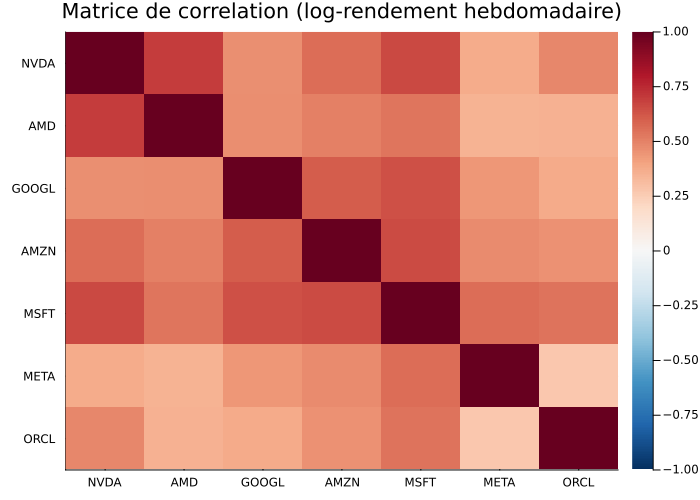

In [7]:
# ==============================================================================
# 11. MATRICE DE CORRÉLATION (IA uniquement : 7 premiers actifs)
# ==============================================================================
using Plots, Statistics

# --- Sélection des 7 premiers actifs (comme ton tableau μ/σ IA)
k = 7
tickers_ia = tickers_all[1:k]
X_ia = X[:, 1:k]          # mêmes dates, seulement les 7 colonnes IA

# --- Rendements cumulés (log)
cum_ia = cumsum(X_ia, dims=1)
plot(rets_all.Date, cum_ia,
     label = tickers_ia,
     title = "Cumulative weekly log-returns (IA assets)",
     legend = :outerright)

# --- Matrice de corrélation
Corr_ia = cor(X_ia)  # Statistics.cor
heatmap(tickers_ia, tickers_ia, Corr_ia,
        c = cgrad(:RdBu, rev=true),
        clims = (-1, 1),
        title = "Matrice de correlation (log-rendement hebdomadaire)",
        yflip = true,   
        size = (700, 500))


In [8]:
using Statistics

Corr_ia = cor(X_ia)

round.(Corr_ia, digits = 2)


7×7 Matrix{Float64}:
 1.0   0.7   0.46  0.56  0.66  0.37  0.49
 0.7   1.0   0.47  0.51  0.54  0.35  0.35
 0.46  0.47  1.0   0.61  0.64  0.44  0.38
 0.56  0.51  0.61  1.0   0.66  0.47  0.46
 0.66  0.54  0.64  0.66  1.0   0.56  0.54
 0.37  0.35  0.44  0.47  0.56  1.0   0.27
 0.49  0.35  0.38  0.46  0.54  0.27  1.0

In [35]:
# ==============================================================================
# 12. ÉVALUATION DU RISQUE : ESTIMATION D'UNE PROBAILITÉ RARE
# ==============================================================================

using LinearAlgebra, Statistics, Distributions, DataFrames, Random, Printf, Latexify


Random.seed!(123)

# 1) Estimation (μ, Σ) et portefeuille x
d = size(X_ia, 2)
μ = vec(mean(X_ia, dims=1))
Σ = cov(X_ia)

x = fill(1/d, d)  # égal-pondéré

# 2) Loi de perte (exactement vraie si ξ gaussien et L linéaire)
μ_L = -dot(x, μ)
σ_L = sqrt(x' * Σ * x)
dist_L = Normal(μ_L, σ_L)

# 3) Seuils queue profonde : c = μ_L + k σ_L
k_vals = [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
c_vals = μ_L .+ k_vals .* σ_L

# 4) P1 sampling-free (analytique, stable via logccdf)
log10P1 = [logccdf(dist_L, c) / log(10) for c in c_vals]
P1 = 10 .^ log10P1

# 5) Monte Carlo standard (N petit) — pour montrer la décadence
N = 100_000
# (on simule L directement, ce qui est équivalent à simuler ξ puis projeter)
L_std = rand(dist_L, N)
MC_count = [count(>=(c), L_std) for c in c_vals]
P_MC = MC_count ./ N
log10MC = [p == 0.0 ? -Inf : log10(p) for p in P_MC]

# 6) Monte Carlo de référence (Nref très grand) — benchmark numérique
Nref = 1_000_000_000
chunk = 1_000_000  # taille de bloc (ajuste si besoin)

# Choisis le mode :
# :L_only  -> simule directement L ~ Normal(μ_L, σ_L) (rapide, MC pur sur L)
# :xi_full -> simule ξ ~ MvNormal(μ, Σ) puis L = -ξ*x (plus lourd)
mode_ref = :L_only

ref_counts = zeros(Int64, length(c_vals))
n_done = 0

if mode_ref == :L_only
    while n_done < Nref
        n = min(chunk, Nref - n_done)
        Lb = rand(dist_L, n) # (n)
        @inbounds for j in eachindex(c_vals)
            ref_counts[j] += count(>=(c_vals[j]), Lb)
        end
        n_done += n
    end
elseif mode_ref == :xi_full
    dist = MvNormal(μ, Σ)
    while n_done < Nref
        n = min(chunk, Nref - n_done)
        Rb = rand(dist, n)'     # (n × d) en bloc
        Lb = -Rb * x            # (n)
        @inbounds for j in eachindex(c_vals)
            ref_counts[j] += count(>=(c_vals[j]), Lb)
        end
        n_done += n
    end
else
    error("mode_ref doit être :L_only ou :xi_full")
end

P_ref = ref_counts ./ Nref
log10Pref = [p == 0.0 ? -Inf : log10(p) for p in P_ref]

# 7) Erreurs type Tong (log10)
# epsilon_LDT_1 = log10(P1) - log10(P_ref)
# epsilon_MC_N  = log10(P_MC) - log10(P_ref)
eps_LDT1 = log10P1 .- log10Pref
eps_MCN  = log10MC  .- log10Pref

# 8) Tableau final "Tong-like"
df = DataFrame(
    k = k_vals,
    P_ref_MC_Nref = P_ref,
    P1 = P1,
    P_MC_N = P_MC,
    M_MC_N = MC_count,
    eps_LDT1 = eps_LDT1,
    eps_MCN = eps_MCN
)

println("\n===== TABLEAU 2 : Comparaison entre la probabilité de référence Monte Carlo et P_1=====\n")
show(df, allcols=true); println("\n")




===== TABLEAU 2 : Comparaison entre la probabilité de référence Monte Carlo et P_1=====

7×7 DataFrame
 Row │ k        P_ref_MC_Nref  P1           P_MC_N   M_MC_N  eps_LDT1      eps_MCN       
     │ Float64  Float64        Float64      Float64  Int64   Float64       Float64       
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     3.0     0.00135011  0.0013499    0.00132     132  -6.85116e-5     -0.00979554
   2 │     3.5     0.00023227  0.000232629  0.00021      21   0.000670881    -0.0437738
   3 │     4.0     3.1297e-5   3.16712e-5   2.0e-5        2   0.00516238     -0.194473
   4 │     4.5     3.425e-6    3.39767e-6   0.0           0  -0.00347898   -Inf
   5 │     5.0     2.94e-7     2.86652e-7   0.0           0  -0.010993     -Inf
   6 │     5.5     2.2e-8      1.89896e-8   0.0           0  -0.0639077    -Inf
   7 │     6.0     2.0e-9      9.86588e-10  0.0           0  -0.306894     -Inf



In [28]:
# ==============================================================================
# 13. ALLOCATION OPTIMALE SOUS CONTRAINTE EN CHANCE RARES
# ==============================================================================

using DataFrames
using Random
using LinearAlgebra
using Statistics
using Distributions
using JuMP
using Ipopt
using OSQP   # Pkg.add("OSQP")

"""
dominant_point_gaussian(u, z, μ, Σ)

Event: loss = -u'ξ ≥ z  ⇔  u'ξ ≤ -z.
Dominant point on boundary u'ξ = -z for Gaussian reference.

Returns: ξ_star, t, I, λ
- t = (z + u'μ)/sqrt(u'Σu)  (tail index, should be > 0 in rare regime)
- I = 0.5*t^2               (rate)
- ξ_star = μ - λ Σ u
- λ = (u'μ + z)/(u'Σu)
"""
function dominant_point_gaussian(u::AbstractVector, z::Real, μ::AbstractVector, Σ::AbstractMatrix)
    s2 = dot(u, Σ*u)
    @assert s2 > 0 "u'Σu must be positive."

    m  = dot(u, μ)
    λ  = (m + z) / s2
    ξs = μ .- λ .* (Σ*u)

    t  = (z + m) / sqrt(s2)
    I  = 0.5 * t^2
    return ξs, t, I, λ
end

"""
P1_first_order(u, z, μ, Σ)

First-order rare-event approximation for P(loss ≥ z) = P(u'ξ ≤ -z).
For large t>0: Φ(-t) ~ ϕ(t)/t (Mills ratio).
We use:
P1 = exp(-0.5*t^2) / (sqrt(2π)*t)

Returns: P1, logP1, t, I
"""
function P1_first_order(u::AbstractVector, z::Real, μ::AbstractVector, Σ::AbstractMatrix; ϵ::Real=1e-12)
    _, t, I, _ = dominant_point_gaussian(u, z, μ, Σ)
    t_eff = max(t, ϵ)  # avoid log(0)
    logP1 = -0.5*t_eff^2 - 0.5*log(2π) - log(t_eff)
    P1    = exp(logP1)
    return P1, logP1, t, I
end



"""
    mc_prob_and_var_cvar_loss(u, z, μ, Σ; N=200_000, alpha=0.01, seed=1234)

Simule ξ ~ N(μ,Σ), calcule les pertes L = -u'ξ.
Retourne :
- mc       = P̂(L ≥ z)
- hits     = nombre de dépassements
- lo, hi   = IC binomial (Wilson) pour P(L ≥ z)
- VaR_MC   = quantile empirique de L au niveau 1-alpha (VaR_{1-alpha})
- CVaR_MC  = moyenne des pertes au-delà de VaR_MC (ES_{1-alpha})
"""
function mc_prob_and_var_cvar_loss(u::Vector{Float64}, z::Float64,
                                   μ::Vector{Float64}, Σ::AbstractMatrix;
                                   N::Int=200_000, alpha::Real=0.01, seed::Int=1234)

    Random.seed!(seed)

    Σmat = Matrix(Σ)
    mv = MvNormal(μ, Σmat)

    # Tirages : d x N
    X = rand(mv, N)

    # Pertes : L = -u'ξ  -> vecteur N
    losses = -vec(u' * X)

    # Probabilité de dépassement au seuil z
    hits = count(>=(z), losses)
    mc = hits / N

    # IC Wilson (95%)
    zcrit = quantile(Normal(), 0.975)
    phat = mc
    denom = 1 + zcrit^2 / N
    center = (phat + zcrit^2/(2N)) / denom
    half = (zcrit * sqrt(phat*(1-phat)/N + zcrit^2/(4N^2))) / denom
    lo = max(0.0, center - half)
    hi = min(1.0, center + half)

    # VaR_MC = quantile au niveau 1-alpha (queue droite des pertes)
    VaR_MC = quantile(losses, 1 - alpha)

    # CVaR_MC = E[L | L >= VaR_MC] (approx empirique)
    # On prend les pires alpha-fraction. Plus stable qu'un simple conditionnement avec ties.
    k = max(1, ceil(Int, float(alpha) * N))
    Ls = sort(losses)              # croissant
    idx = N - k + 1                # début des pires k pertes
    CVaR_MC = mean(@view Ls[idx:N])

    return mc, hits, lo, hi, VaR_MC, CVaR_MC
end


"""
    build_table_52(portfolios, μ, Σ; alpha=0.01, Nmc=200_000, seed=1234,
                   z_hi=0.30, bisect_iters=80, tol_sum=1e-8, tol_long=1e-12)

Returns a DataFrame with:
- method, z_star
- P1 (first-order prob at z_star)
- MC, hits, MC_lo, MC_hi (Monte Carlo prob + binomial CI)
- VaR_MC (empirical VaR_{1-alpha} from MC losses)
- Delta  = VaR_MC - z_star
- t, I
- time_sec
"""
function build_table_52(portfolios::Dict{String,Vector{Float64}},
                        μ::Vector{Float64}, Σ::AbstractMatrix;
                        alpha::Real=0.01,
                        Nmc::Int=200_000,
                        seed::Int=1234,
                        z_hi::Float64=0.30,
                        bisect_iters::Int=80,
                        tol_sum::Float64=1e-8,
                        tol_long::Float64=1e-12)

    Σmat = Matrix(Σ)

    rows = DataFrame(
        method   = String[],
        z_star   = Float64[],
        P1       = Float64[],
        MC       = Float64[],
        hits     = Int[],
        MC_lo    = Float64[],
        MC_hi    = Float64[],
        VaR_MC   = Float64[],
        CVaR_MC  = Float64[],
        Delta    = Float64[],
        t        = Float64[],
        I        = Float64[],
        time_sec = Float64[]
    )

    function _check_u(name::String, u::Vector{Float64})
        s = sum(u)
        if abs(s - 1.0) > tol_sum
            @warn "Weights do not sum to 1; normalizing" method=name sum=s
            u = u ./ s
        end
        if minimum(u) < -tol_long
            @warn "Found negative weights (not long-only)" method=name min_u=minimum(u)
        end
        return u
    end

    function _solve_z_star(u, μ, Σmat; alpha, z_lo=0.0, z_hi=z_hi, iters=bisect_iters)
        P1_lo, _, _, _ = P1_first_order(u, z_lo, μ, Σmat)
        if P1_lo < alpha
            @warn "alpha too large or z_lo too high; returning z_lo" P1_lo alpha
            return z_lo
        end

        zH = z_hi
        P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
        expand = 0
        while P1_hi > alpha && expand < 30
            zH *= 1.5
            P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
            expand += 1
        end
        if P1_hi > alpha
            @warn "Could not bracket root; alpha may be too small for current z range" alpha zH P1_hi
            return zH
        end

        zL = z_lo
        for _ in 1:iters
            zM = 0.5*(zL + zH)
            P1_mid, _, _, _ = P1_first_order(u, zM, μ, Σmat)
            if P1_mid > alpha
                zL = zM
            else
                zH = zM
            end
        end
        return zH
    end

    for name in sort(collect(keys(portfolios)))
        u0 = portfolios[name]
        t_start = time_ns()

        u = _check_u(name, copy(u0))

        # 1) z* via inversion P1(u,z*) = alpha
        z_star = _solve_z_star(u, μ, Σmat; alpha=alpha)

        # 2) LDT quantities at z*
        P1, ξ_star, tval, Ival = P1_first_order(u, z_star, μ, Σmat)

        # 3) MC at z* + VaR_MC
        # (seed différent par méthode, mais déterministe)
        seed_i = seed + Int(mod(hash(name), 1_000_000))
        mc, hits, lo, hi, var_mc, cvar_mc = mc_prob_and_var_cvar_loss(u, z_star, μ, Σmat;
                                                        N=Nmc, alpha=alpha, seed=seed_i)

        Δ = var_mc - z_star
        time_sec = (time_ns() - t_start) / 1e9

        push!(rows, (name, z_star, P1, mc, hits, lo, hi, var_mc, cvar_mc, Δ, tval, Ival, time_sec))
    end

    return rows
end


"""
solve_var_optimization_P1(μ, Σ; alpha=0.01, z0=0.05, maxiter=4000)

Résout :
    max_{u,z}  z
s.c.
    u ≥ 0,  sum(u)=1,  z ≥ 0
    logP1(u,z) ≤ log(alpha)

où
    t(u,z) = (z + u'μ) / sqrt(u'Σu)
    logP1  = -0.5 t^2 - 0.5 log(2π) - log(t)   (Mills ratio)
"""
function solve_var_optimization_P1(μ::AbstractVector, Σ::AbstractMatrix;
                                   alpha::Real=0.01,
                                   z0::Real=0.05,
                                   maxiter::Int=4000,
                                   silent::Bool=true)

    d = length(μ)
    @assert size(Σ,1) == d && size(Σ,2) == d "Σ must be d×d."

    Σm = Matrix(Σ)  # ensure dense for NL expressions

    model = Model(Ipopt.Optimizer)
    if silent
        set_silent(model)
    end
    set_optimizer_attribute(model, "max_iter", maxiter)

    # Variables
    @variable(model, u[1:d] >= 0.0)
    @variable(model, z >= 0.0)

    # Budget
    @constraint(model, sum(u) == 1.0)

    # Warm start (helps Ipopt)
    for i in 1:d
        set_start_value(u[i], 1/d)
    end
    set_start_value(z, z0)

    # Numerics
    eps = 1e-12

    # Nonlinear expressions
    @NLexpression(model, s2, sum(Σm[i,j] * u[i] * u[j] for i in 1:d, j in 1:d))
    @NLexpression(model, m,  sum(μ[i] * u[i] for i in 1:d))
    @NLexpression(model, t,  (z + m) / sqrt(s2 + eps))

    # log P1 ≈ -t^2/2 - 0.5 log(2π) - log(t)
    @NLexpression(model, logP1, -0.5*t^2 - 0.5*log(2π) - log(t + eps))

    # Chance constraint (first-order)
    @NLconstraint(model, logP1 <= log(alpha))

    # Objective: maximize VaR threshold z
    @objective(model, Max, z)

    optimize!(model)

    u_star = value.(u)
    z_star = value(z)

    return u_star, z_star, model
end


"Portefeuille équipondéré"
function w_equal(d::Int)
    fill(1.0/d, d)
end

"Portefeuille max rendement: max u'μ s.c. sum(u)=1, u>=0"
function w_max_return(μ::AbstractVector)
    d = length(μ)
    m = Model(OSQP.Optimizer)
    set_silent(m)

    @variable(m, u[1:d] >= 0)
    @constraint(m, sum(u) == 1)
    @objective(m, Max, sum(μ[i] * u[i] for i in 1:d))
    optimize!(m)

    return value.(u)
end

"Portefeuille minimum variance: min u'Σu s.c. sum(u)=1, u>=0"
function w_min_variance(Σ::AbstractMatrix)
    d = size(Σ, 1)
    m = Model(OSQP.Optimizer)
    set_silent(m)

    @variable(m, u[1:d] >= 0)
    @constraint(m, sum(u) == 1)

    @objective(m, Min, u' * Σ * u)
    set_optimizer_attribute(m, "eps_abs", 1e-9)
    set_optimizer_attribute(m, "eps_rel", 1e-9)
    optimize!(m)

    return value.(u)
end

"""
    sanitize_weights(u; tol_neg=1e-10)

- met à 0 les petits négatifs (>= -tol_neg)
- renormalise pour forcer sum(u)=1
- renvoie u propre
"""
function sanitize_weights(u::AbstractVector; tol_neg::Float64=1e-10)
    u2 = copy(u)
    # clamp petits négatifs
    for i in eachindex(u2)
        if u2[i] < 0 && u2[i] > -tol_neg
            u2[i] = 0.0
        end
    end
    # si encore négatif "réel", on avertit
    if minimum(u2) < 0
        @warn "Negative weight beyond tolerance" min_u=minimum(u2)
        # option stricte: clamp tout à 0
        u2 .= max.(u2, 0.0)
    end
    s = sum(u2)
    if s == 0
        error("All weights are zero after sanitization.")
    end
    return u2 ./ s
end


sanitize_weights

In [29]:
u_equal   = sanitize_weights(w_equal(length(μ)))
u_maxret  = sanitize_weights(w_max_return(μ))
u_minvar   = sanitize_weights(w_min_variance(Σ))


# 5.2: solve optimal VaR portfolio (P1 constraint)
alpha = 1e-4

u_opt, z_opt, model = solve_var_optimization_P1(μ, Σ; alpha=alpha, z0=0.05)
u_opt = sanitize_weights(u_opt)
@info "Opt VaR portfolio" z_opt sum(u_opt) minimum(u_opt)

# Build Tong-like table at alpha for the reference portfolios
portfolios = Dict(
    "Equal"   => u_equal,
    "MinVar"  => u_minvar,
    "MaxRet"  => u_maxret,
    "OptVaR"  => u_opt
)

tbl52 = build_table_52(portfolios, μ, Σ; alpha=alpha, Nmc=200_000, seed=123, z_hi=0.30, bisect_iters=80, tol_sum=1e-8, tol_long=1e-12)
tbl52


┌ Warning: Negative weight beyond tolerance
│   min_u = -6.226559710886508e-10
└ @ Main In[28]:348
┌ Warning: Negative weight beyond tolerance
│   min_u = -9.999991050866826e-9
└ @ Main In[28]:348
┌ Info: Opt VaR portfolio
│   z_opt = 2.646641316415657e8
│   sum(u_opt) = 1.0
└   minimum(u_opt) = 0.0


Row,method,z_star,P1,MC,hits,MC_lo,MC_hi,VaR_MC,CVaR_MC,Delta,t,I,time_sec
,String,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Equal,0.146533,0.0001,9.0e-5,18,5.69325e-5,0.000142271,0.144451,0.154326,-0.00208273,3.73464,6.97375,0.0384502
2,MaxRet,0.246896,0.0001,9.5e-5,19,6.08218e-5,0.000148381,0.244682,0.258256,-0.00221403,3.73464,6.97375,0.103424
3,MinVar,0.120573,0.0001,0.000105,21,6.86808e-5,0.000160522,0.120578,0.12936,4.57932e-6,3.73464,6.97375,0.0378328
4,OptVaR,0.261993,0.0001,5.5e-5,11,3.07125e-5,9.84924e-5,0.250243,0.267384,-0.0117501,3.73464,6.97375,0.0566283


In [32]:
# ==============================================================================
# 14. ANALYSE DES POINTS DOMINANTS
# ==============================================================================

using DataFrames
using LinearAlgebra
using Statistics
using PrettyTables

"""
P1_first_order(u, z, μ, Σ)

Event: L(u,ξ) = -u'ξ >= z  <=>  u'ξ <= -z
Reference model: ξ ~ N(μ, Σ)

Returns:
(P1, ξ_star, t, I)

- ξ_star is the dominant point (Vector length n)
- t is the normalized distance (>=0 for rare losses)
- I = 0.5*t^2 is the rate
- P1 uses Mills ratio approximation: exp(-t^2/2)/(sqrt(2π)*t)
"""
function P1_first_order(u::AbstractVector, z::Real, μ::AbstractVector, Σ::AbstractMatrix)
    u = collect(u)
    μ = collect(μ)
    Σmat = Matrix(Σ)

    Σu = Σmat * u
    denom = dot(u, Σu)  # u'Σu

    m = dot(u, μ)       # u'μ
    numer = z + m       # z + u'μ

    # If numer <= 0, the event is not rare (threshold below/at mean loss)
    # We still return a consistent ξ_star on the boundary and a coarse prob.
    if denom <= 0
        error("u'Σu must be > 0 (check Σ PSD and u nonzero).")
    end

    t = numer / sqrt(denom)
    I = 0.5 * t^2

    # dominant point on boundary u'ξ = -z
    λ = numer / denom
    ξ_star = μ .- λ .* Σu   # Vector length n

    # Mills ratio (first-order tail)
    if t <= 1e-12
        # not rare: P(L>=z) around 0.5 or larger; Mills isn't valid
        P1 = 0.5
    else
        P1 = exp(-0.5*t^2) / (sqrt(2π) * t)
    end

    return P1, ξ_star, t, I
end







"""
    dominant_points_table(portfolios, tickers, μ, Σ;
                          alpha=0.01, zstars=nothing, topk=5)

Construit un tableau long (format tidy) avec les composantes du point dominant ξ* par titre.
- portfolios :: Dict(name => u::Vector{Float64})
- tickers    :: Vector{String} (même ordre que μ et les colonnes de Σ)
- μ, Σ       :: paramètres gaussiens
- zstars     :: Dict(name => z_star) optionnel (scalaire par portefeuille).
              Si absent (nothing), on calcule z_star par inversion P1.
- topk       :: si >0, retourne aussi un tableau "top contributions" par portefeuille.

Retour:
- df_full : DataFrame (portfolio, z_star, ticker, u, xi_star, shock, contrib_loss, abs_contrib_share)
- df_top  : DataFrame (topk contributions par portefeuille), ou nothing
"""
function dominant_points_table(portfolios::Dict{String,Vector{Float64}},
                               tickers::Vector{String},
                               μ::Vector{Float64},
                               Σ::AbstractMatrix;
                               alpha::Real=0.01,
                               zstars::Union{Nothing,Dict{String,Float64}}=nothing,
                               topk::Int=5)

    Σmat = Matrix(Σ)
    n = length(μ)
    @assert length(tickers) == n
    for (name,u) in portfolios
        @assert length(u) == n "Portfolio $name has wrong length"
    end

    # --- helper: compute z* by bisection if not provided ---
    function solve_z_star(u; alpha=alpha, z_lo=0.0, z_hi=0.30, iters=80)
        P1_lo, _, _, _ = P1_first_order(u, z_lo, μ, Σmat)
        if P1_lo < alpha
            @warn "P1(z_lo) < alpha: returning z_lo (alpha too large or z_lo too high)" P1_lo alpha z_lo
            return z_lo
        end

        # expand z_hi until P1(z_hi) <= alpha (bracketing)
        zH = z_hi
        P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
        k = 0
        while P1_hi > alpha && k < 30
            zH *= 1.5
            P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
            k += 1
        end
        if P1_hi > alpha
            @warn "Could not bracket root; returning expanded zH" alpha zH P1_hi
            return zH
        end

        # bisection on [z_lo, zH]
        zL = z_lo
        for _ in 1:iters
            zM = 0.5*(zL + zH)
            P1_mid, _, _, _ = P1_first_order(u, zM, μ, Σmat)
            if P1_mid > alpha
                zL = zM
            else
                zH = zM
            end
        end
        return zH
    end

    rows = DataFrame(
        portfolio = String[],
        z_star    = Float64[],
        ticker    = String[],
        u         = Float64[],
        xi_star   = Float64[],
        shock     = Float64[],
        contrib_loss = Float64[],
        abs_contrib_share = Float64[]
    )

    # --- compute for each portfolio ---
    for name in sort(collect(keys(portfolios)))
        u0 = portfolios[name]
        s = sum(u0)
        if abs(s - 1.0) > 1e-8
            @warn "Weights do not sum to 1; normalizing" method=name sum=s
        end
        u = u0 ./ s

        if minimum(u) < -1e-12
            @warn "Found negative weights (not long-only, numerical)" method=name min_u=minimum(u)
        end

        # IMPORTANT: z_star is a SCALAR per portfolio
        z_star = if isnothing(zstars)
            solve_z_star(u; alpha=alpha)
        else
            if !haskey(zstars, name)
                @warn "zstars provided but missing key; computing z_star by inversion" method=name
                solve_z_star(u; alpha=alpha)
            else
                zstars[name]  # <-- scalar Float64 (NO indexing!)
            end
        end

        # P1_first_order must return ξ_star as Vector{Float64} of length n
        _, ξ_star, _, _ = P1_first_order(u, z_star, μ, Σmat)

        @assert length(ξ_star) == n "ξ_star returned by P1_first_order has wrong length for $name"

        shock = ξ_star .- μ                 # choc par titre
        contrib_loss = -u .* ξ_star         # contribution à L=-u'ξ
        denom = sum(abs.(contrib_loss)) + eps()
        share = abs.(contrib_loss) ./ denom

        for i in 1:n
            push!(rows, (name, z_star, tickers[i], u[i], ξ_star[i], shock[i],
                         contrib_loss[i], share[i]))
        end
    end

    # --- top-k contributions table (optionnel) ---
    df_top = nothing
    if topk > 0
        df_top = combine(groupby(rows, :portfolio)) do g
            g_sorted = g[sortperm(g.abs_contrib_share, rev=true), :]
            first(g_sorted, min(topk, n))
        end

        # rank per portfolio (1..topk)
        df_top = transform(groupby(df_top, :portfolio),
                           :abs_contrib_share => (x -> 1:length(x)) => :rank)

        select!(df_top, :portfolio, :rank, :ticker, :u, :xi_star, :shock,
                :contrib_loss, :abs_contrib_share, :z_star)
    end

    return rows, df_top
end

"""
Option: export LaTeX table via PrettyTables.
"""
function to_latex_table(df::DataFrame; caption="Dominant point components", label="tab:xi_star")
    io = IOBuffer()
    pretty_table(io, df; backend=:latex, caption=caption, label=label)
    return String(take!(io))
end


to_latex_table

In [33]:
# exemple: zstars depuis ton build_table_52
# 1) Estimation (μ, Σ) sur les actifs IA
d = size(X_ia, 2)
μ = vec(mean(X_ia, dims=1))
Σ = cov(X_ia)
zstars = Dict(row.method => row.z_star for row in eachrow(tbl52))

df_xi, df_top = dominant_points_table(portfolios, tickers_ia, μ, Σ;
                                      alpha=1e-4, zstars=zstars, topk=7)

first(df_xi, 10), df_top


(10×8 DataFrame
 Row │ portfolio  z_star    ticker  u           xi_star     shock      contrib ⋯
     │ String     Float64   String  Float64     Float64     Float64    Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Equal      0.146533  NVDA    0.142857    -0.204547   -0.214048   0.0292 ⋯
   2 │ Equal      0.146533  AMD     0.142857    -0.204984   -0.203957   0.0292
   3 │ Equal      0.146533  GOOGL   0.142857    -0.116757   -0.118664   0.0166
   4 │ Equal      0.146533  AMZN    0.142857    -0.139454   -0.141142   0.0199
   5 │ Equal      0.146533  MSFT    0.142857    -0.109177   -0.111073   0.0155 ⋯
   6 │ Equal      0.146533  META    0.142857    -0.152773   -0.156948   0.0218
   7 │ Equal      0.146533  ORCL    0.142857    -0.0980422  -0.102358   0.0140
   8 │ MaxRet     0.246896  NVDA    0.991974    -0.248081   -0.257583   0.2460
   9 │ MaxRet     0.246896  AMD     0.00133771  -0.184159   -0.183132   0.0002 ⋯
  10 │ MaxRet     0.2468